In [1]:
import string
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

In [2]:
sns.set_theme(color_codes=True, style='ticks', context='talk', font_scale=1.5)

NROWS, NCOLS = 3, 3
SAMPLE_SIZES = [256, 512, 1024, 2048, 4096]
DIM_SIZES = [2**i for i in range(2, 13)]
DATA_PATH = "results"
FIG_PATH = "figs"

SIMULATIONS = [
    "linear",
    "nonlinear",
    "independent",
]

S98_KWARGS = {
    # "SVMrbf" : {"color" : "#ff7f00", "label" : "SVM"},
    # "LRliblinear" : {"color" : "#984ea3", "label" : "LR"},
    "KNN" : {"color" : "#377eb8", "label" : "KNN"},
    # "RF" : {"color" : "#377eb8", "label" : "RF"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.14,
        "nonlinear" : 0.26,
        "independent": 0.02
    }
}

MI_KWARGS = {
    "KSG" : {"color" : "#4daf4a", "label" : "KSG"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.11,
        "nonlinear" : 0.09,
        "independent": 0.00
    }
}

POWER_KWARGS = {
    "Dcorr_PCA" : {"color" : "#ff7f00", "lw" : 2, "label" : "Dcorr PCA", "linestyle" : ":"},
    "Dcorr" : {"color" : "#ff7f00", "lw" : 2, "label" : "Dcorr"},
    "hypoRF" : {"color" : "#984ea3", "lw" : 2, "label" : "hypoRF"},
    "might-Acc" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Acc", "linestyle" : "-."},
    "might-AUC" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT AUC", "linestyle" : "--"},
    "might-MI" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT MI", "linestyle" : ":"},
    "might-S98" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT S@98"},
    "Alpha" : {
        "linear" : 0.05,
        "nonlinear" : 0.05,
        "independent": 0.05
    }
}

HD_KWARGS = {
    "drf" : {"color" : "#999999", "label" : "DRF"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.24,
        "nonlinear" : 0.25,
        "independent": 0.00
    }
}

STAT_KWARGS = {
    "MI" : {"kwargs" : MI_KWARGS, "title" : "MI"},
    "hd" : {"kwargs" : HD_KWARGS, "title" : "Hellinger Distance"},
    "S98" : {"kwargs" : S98_KWARGS, "title" : "S@98"},
}

In [3]:
def plot_stats(plot_type="vs-n", fig_name="figure-2"):
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(16, 14))

    lines = []
    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            stat = list(STAT_KWARGS.keys())[r]
            stat_kwargs = STAT_KWARGS[stat]["kwargs"]
            col.axhline(y=stat_kwargs["Truth"][sim], linestyle=":", color="#000000", label="Truth")

            for test, plot_kwargs in stat_kwargs.items():
                if plot_type == "vs-n":
                    xs = SAMPLE_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-{stat}-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif plot_type == "vs-d":
                    xs = DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-{stat}-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                if stat == "power":
                    line = col.plot(xs, ys, **plot_kwargs)
                else:
                    medians = np.quantile(ys, 0.5, axis=1)
                    lower_quartile = np.quantile(ys, 0.25, axis=1)
                    upper_quartile = np.quantile(ys, 0.75, axis=1)
                    line = col.plot(xs, medians, **plot_kwargs)
                    col.fill_between(xs, lower_quartile, upper_quartile, alpha=0.2, color=plot_kwargs["color"])
                lines.extend(line)

            col.set(
                title=sim.capitalize() if r == 0 else "",
                xlabel=(
                    "Sample Size" if plot_type == "vs-n" and r == 2
                    else "# of Variables" if plot_type == "vs-d" and r == 2
                    else ""
                ),
                ylabel=(
                    f"{STAT_KWARGS[stat]['title']}\nfor 4096 Variables" if plot_type == "vs-n" and c == 0
                    else f"{STAT_KWARGS[stat]['title']}\nfor 4096 Samples" if plot_type == "vs-d" and c == 0
                    else f"{STAT_KWARGS[stat]['title']}\nfor 512 Samples" if plot_type == "vs-d" and c == 0 and stat == "power"
                    else ""
                ),
                yticks=(
                    [0, 1.0] if stat == "power"
                    else [0, stat_kwargs["Truth"][sim], 0.1] if c == 2
                    else [0, stat_kwargs["Truth"][sim]]
                ),
                ylim=(
                    [-0.01, 1.01] if stat == "power"
                    # else [-0.001, 0.1] if c == 2 and stat == "S98"
                    else [-0.001, 0.1] if c == 2 #and stat in ["MI", "hd"]
                    else [-0.001, stat_kwargs["Truth"][sim] + 0.4 * stat_kwargs["Truth"][sim]]
                ),
                xticks=(
                    [256, 2048, 4096] if plot_type == "vs-n"
                    else [4, 2048, 4096] if plot_type == "vs-d"
                    else ""
                )
            )
            col.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
            col.set_title(string.ascii_uppercase[r * NCOLS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)

    legend_locs = [0.99, 0.66, 0.33]
    for i in range(NROWS):
        leg = ax[i, 0].legend(
            bbox_to_anchor=(1.05, legend_locs[i]),
            bbox_transform=plt.gcf().transFigure,
            ncol=1,
            loc="upper center",
            reverse=True
        )
        leg.get_frame().set_linewidth(0.0)
        for legobj in leg.legend_handles:
            legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')


def plot_power(fig_name="figure-4"):
    fig, ax = plt.subplots(nrows=2, ncols=NCOLS, figsize=(18, 12))

    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            col.axhline(y=POWER_KWARGS["Alpha"][sim], linestyle=":", color="#000000", label="Alpha")

            for test, plot_kwargs in POWER_KWARGS.items():
                if r == 0:
                    xs = SAMPLE_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-power-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif r == 1:
                    xs = DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-power-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                col.plot(xs, ys, **plot_kwargs)

            col.set(
                title=sim.capitalize() if r == 0 else "",
                xlabel=(
                    "Sample Size" if r == 0
                    else "# of Variables" if r == 1
                    else ""
                ),
                ylabel=(
                    f"Power\nfor 4096 Variables" if r == 0 and c == 0
                    else f"Power\nfor 512 Samples" if r == 1 and c == 0
                    else ""
                ),
                yticks=[0, 1.0],
                ylim=[-0.01, 1.01],
                xticks=(
                    [256, 2048, 4096] if r == 0
                    else [4, 2048, 4096] if r == 1
                    else ""
                )
            )
            col.set_title(string.ascii_uppercase[r * NCOLS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)

    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.01),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(POWER_KWARGS.keys()) // 2,
        loc="upper center",
        reverse=True
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')

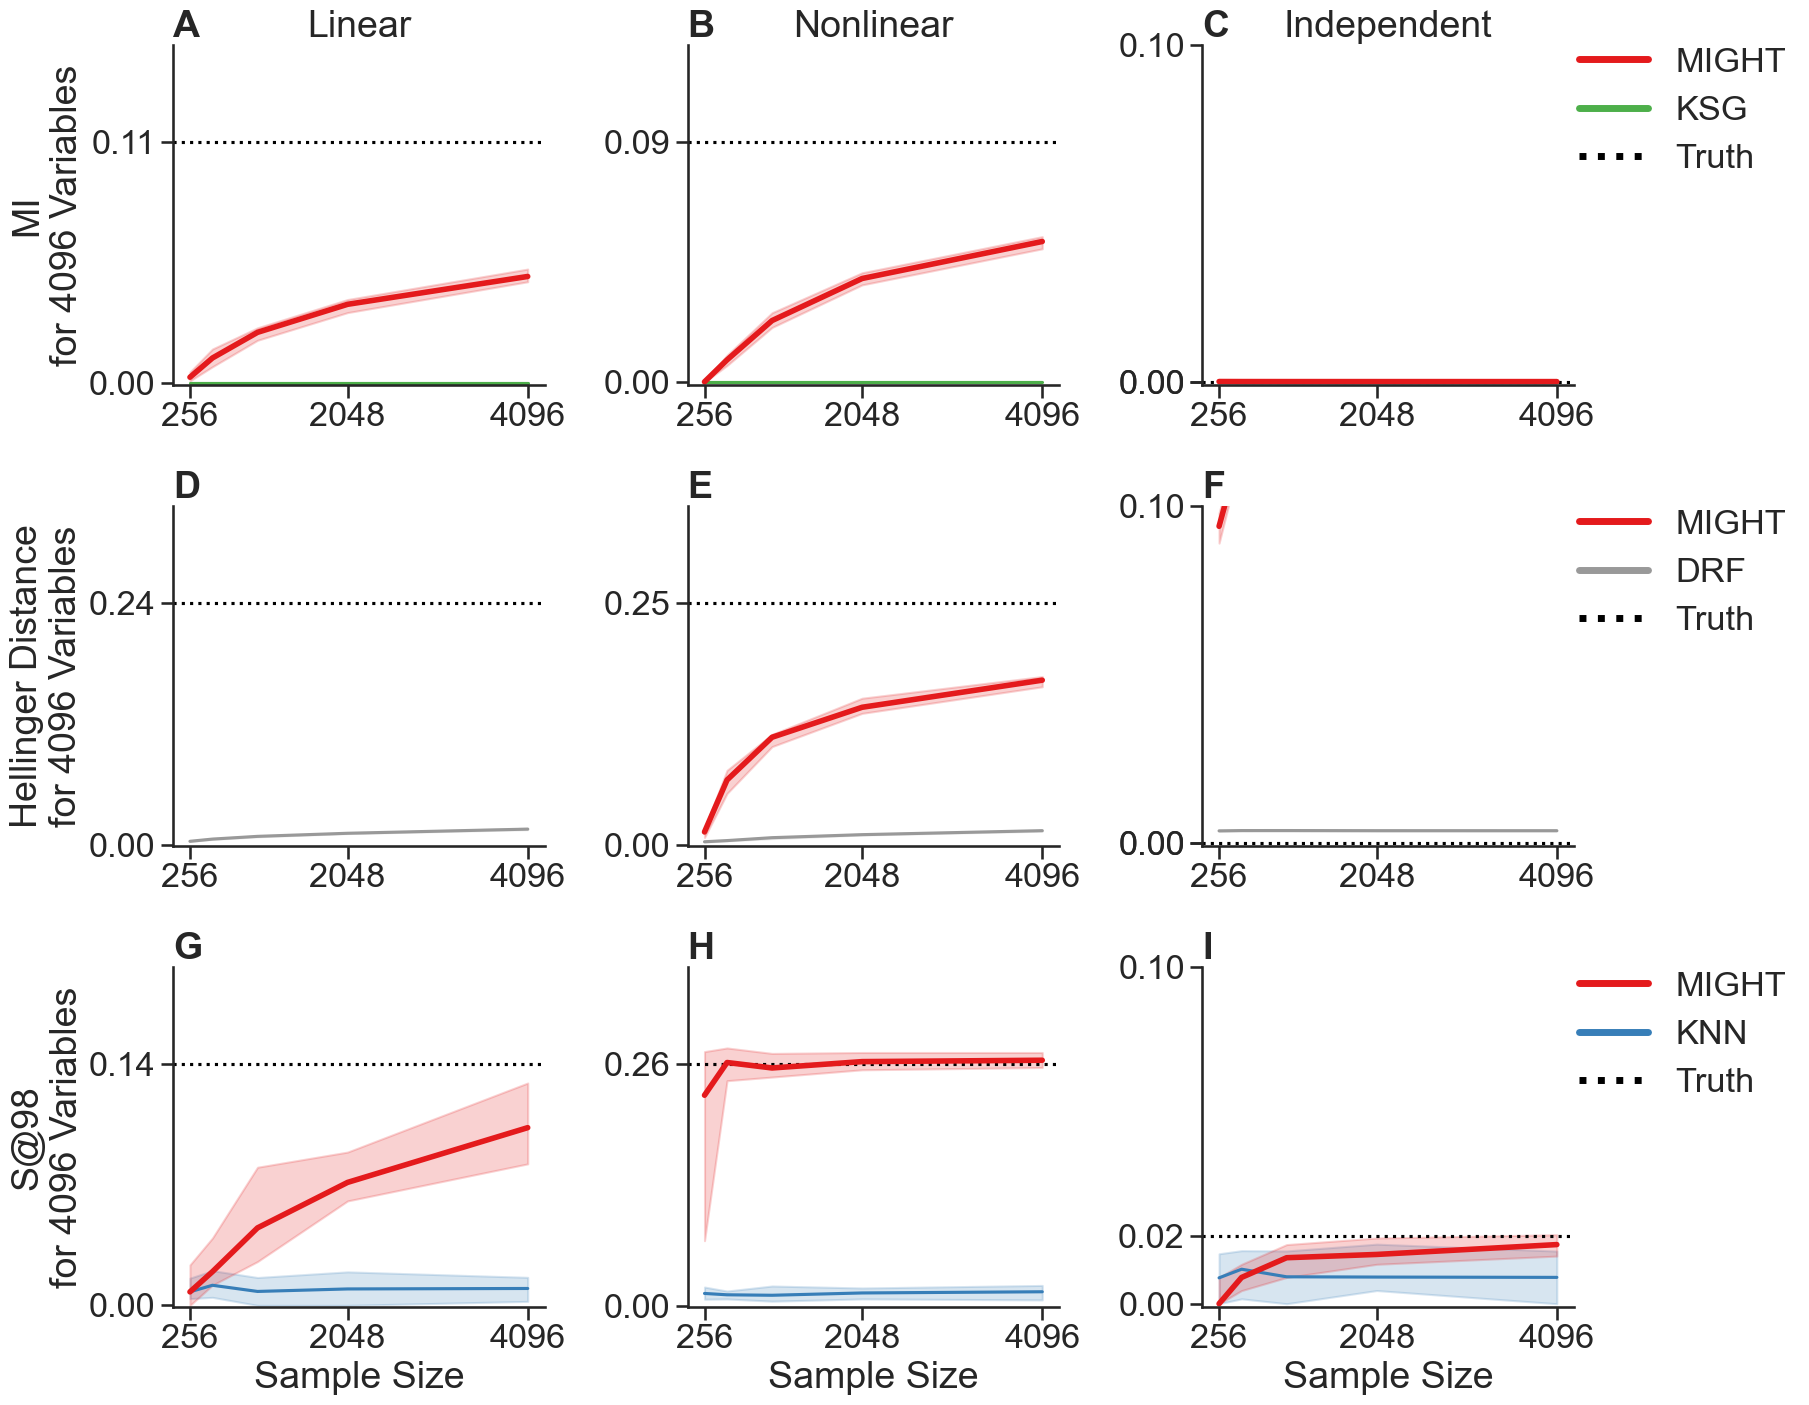

In [4]:
plot_stats(plot_type="vs-n", fig_name="figure-2")

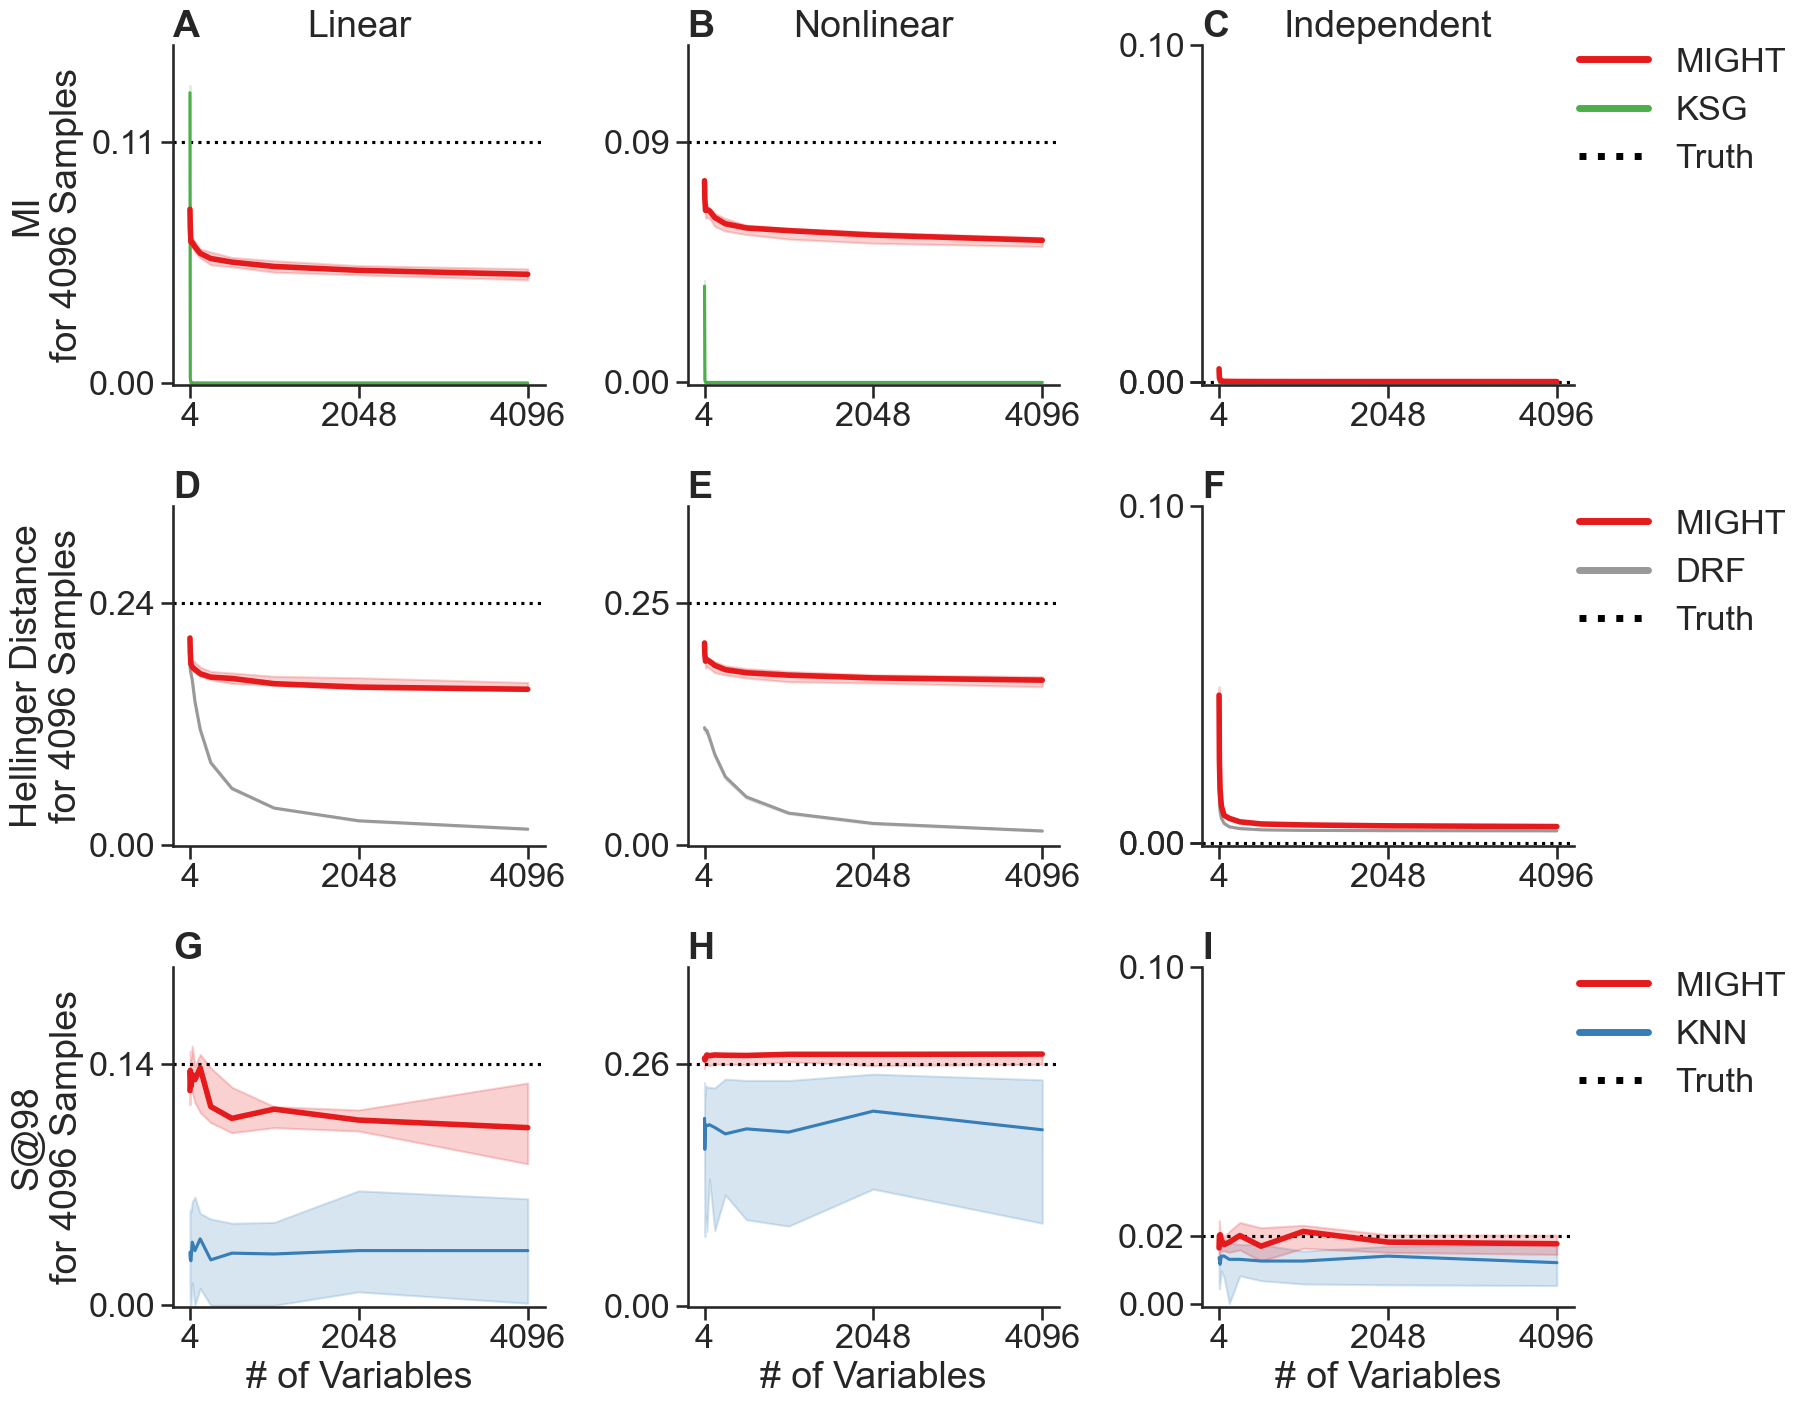

In [179]:
plot_stats(plot_type="vs-d", fig_name="figure-s2")

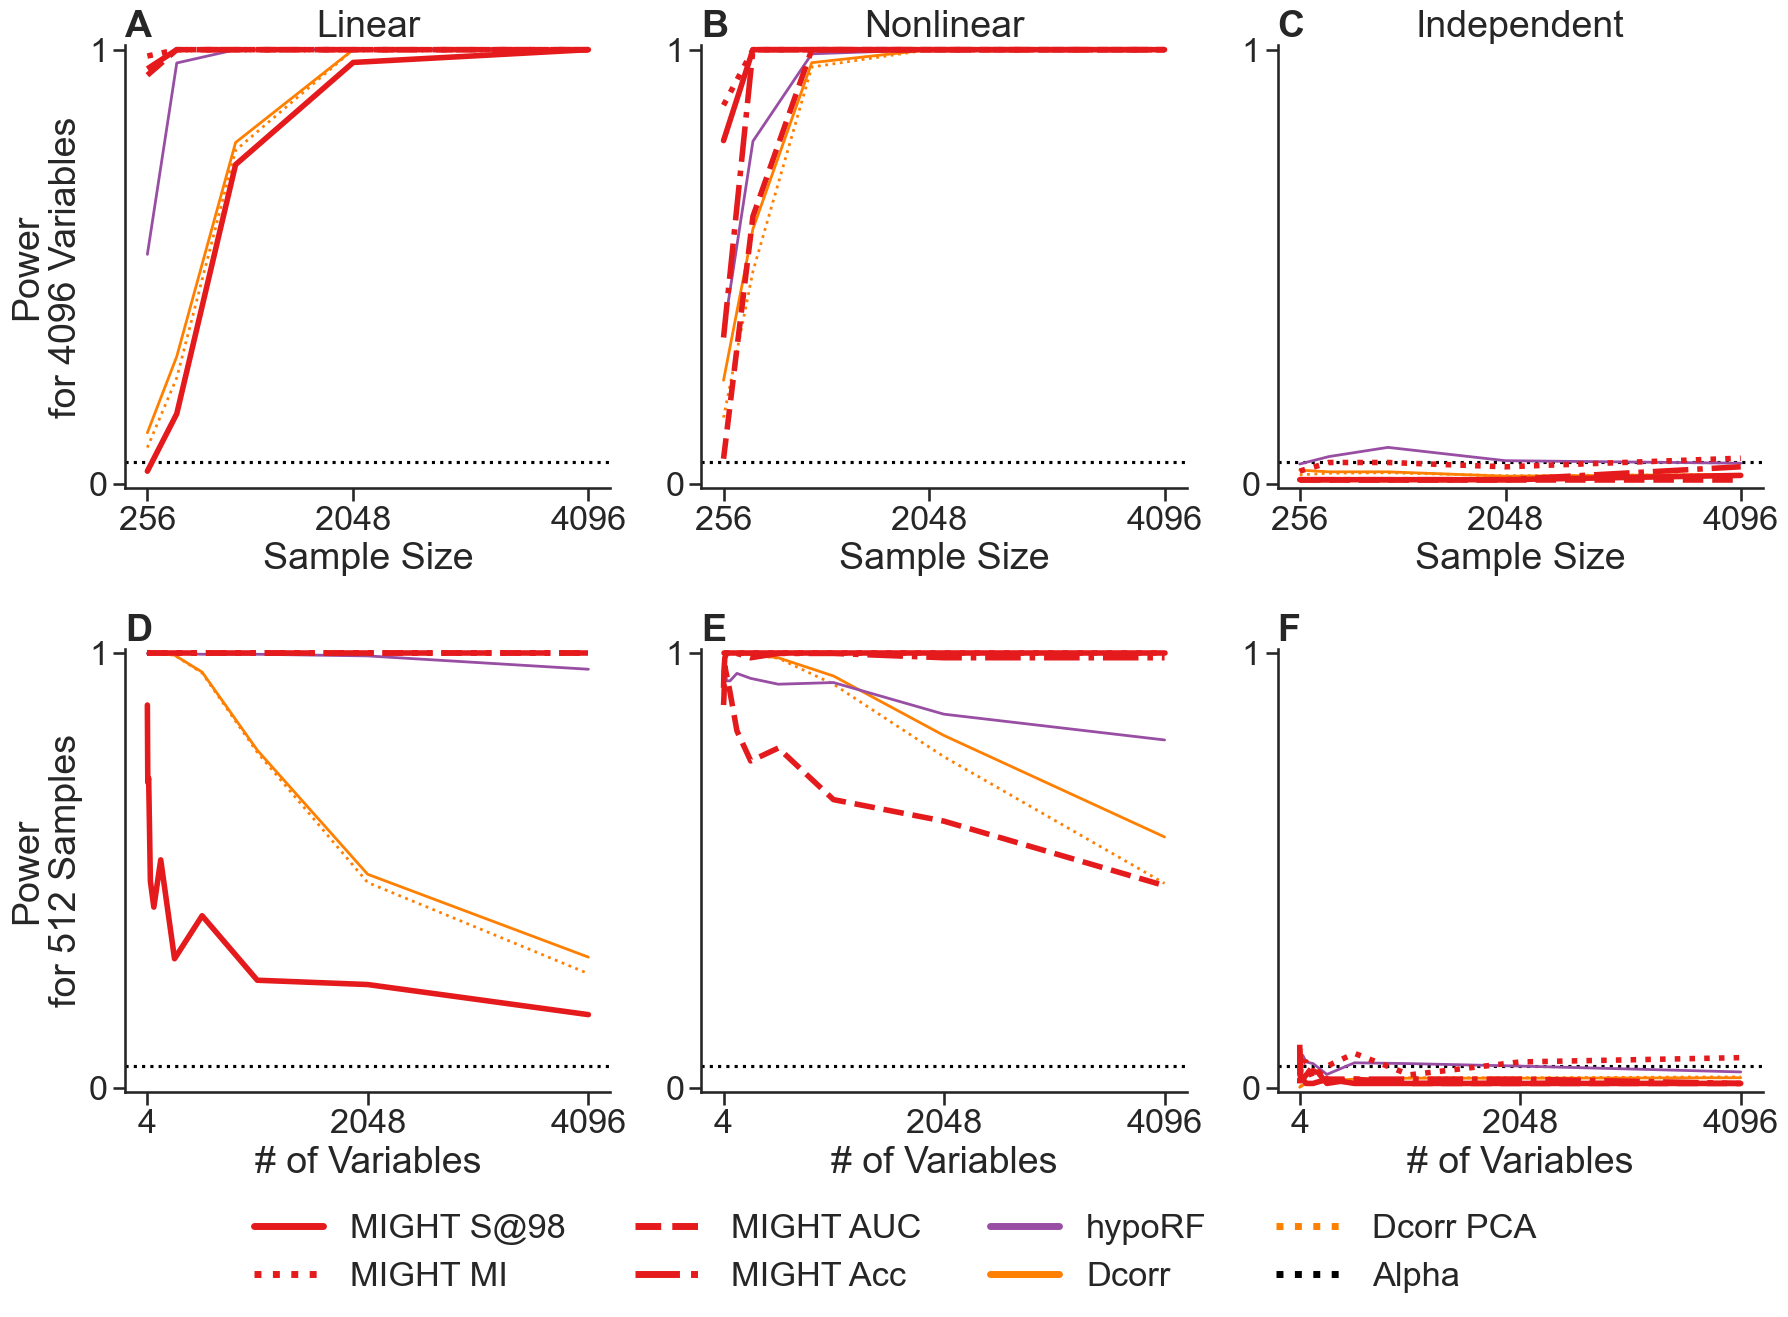

In [182]:
plot_power(fig_name="figure-4")

In [157]:
# Refactor Data
SIMS = {
    "linear" : "trunk",
    "nonlinear" : "trunk_mix",
    "independent" : "trunk_overlap"
}
ALPHA = 0.05
MAX_REPS = {
    "Dcorr" : 1000,
    "Dcorr_PCA" : 1000,
    "hypoRF" : 521,
}


def refactor_data_s98(data, alg="SVMrbf", type="n"):
    df = pd.read_csv(data)
    for sim, file_sim in SIMS.items():
        grouped = df.groupby(df.simulation)
        sim_df = grouped.get_group(SIMS[sim])
        grouped = df.groupby(sim_df.model)
        alg_df = grouped.get_group(alg)
        # print(SIMS[sim], alg)
        # N = alg_df[alg_df["n_sample"] == 4096]["n_dim"].label.value_counts(sort=False).min()
        # print(N)
        # print(alg_df[alg_df["n_sample"] == 4096]["n_dim"].value_counts())
        # print("\n")
        alg_df["n_sample"] = alg_df["n_sample"].astype(int)
        alg_df["n_dim"] = alg_df["n_dim"].astype(int)
        if type == "n":
            vs_sampsize = alg_df[alg_df["n_dim"] == 4096]
            N = vs_sampsize.n_sample.value_counts(sort=False).min()
            N = N - N % len(SAMPLE_SIZES)
            refactored_data = vs_sampsize.sample(frac=1).groupby('n_sample', sort=False).head(N)["s@98"].to_numpy().reshape(len(SAMPLE_SIZES), -1)
        elif type == "d":
            vs_dim = alg_df[alg_df["n_sample"] == 4096]
            N = vs_dim.n_dim.value_counts(sort=False).min()
            N = N - N % len(DIM_SIZES)
            refactored_data = vs_dim.sample(frac=1).groupby('n_dim', sort=False).head(N)["s@98"].to_numpy().reshape(len(DIM_SIZES), -1)
        np.savetxt(f"{DATA_PATH}/{sim}-{alg}-S98-vs-{type}.csv", refactored_data, delimiter=",")


def refactor_data_mi(data, sim="linear", type="n"):
    if type == "n":
        dfs = [
            pd.read_csv(f"{data}/{SIMS[sim]}_mi_samp_rep{rep}.csv", sep=",", header=None)
            for rep in range(10)
        ]
        df = pd.concat(dfs, axis=1)
    elif type == "d":
        dfs = [
            pd.read_csv(f"{data}/{SIMS[sim]}_mi_dim_rep{rep}.csv", sep=",", header=None)
            for rep in range(10)
        ]
        df = pd.concat(dfs, axis=1)
    np.savetxt(f"{DATA_PATH}/{sim}-KSG-MI-vs-{type}.csv", df.to_numpy(), delimiter=",")



def refactor_data_power(alg="Dcorr", sim="linear", type="n"):
    power = []
    if type == "n":
        file_path = f"p-4096_n-256_4096/{sim}_{alg}"
        for samp_size in SAMPLE_SIZES:
            if alg == "hypoRF":
                alt_dist, null_dist = map(
                    np.float64,
                    zip(*[
                        np.genfromtxt(f"{file_path}_{samp_size}_{rep}.txt")
                        for rep in range(MAX_REPS[alg])
                    ]),
                )
                cutoff = np.sort(1 - null_dist)[math.ceil(MAX_REPS[alg] * (1 - ALPHA))]
                empirical_power = (1 + ((1 - alt_dist) >= cutoff).sum()) / (1 + MAX_REPS[alg])
            else:
                pvals = np.array([
                    np.genfromtxt(f"{file_path}_{samp_size}_{rep}.txt")
                    for rep in range(MAX_REPS[alg])
                ])
                empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + MAX_REPS[alg])
            power.append(empirical_power)
    elif type == "d":
        file_path = f"n-512_p-4_4096/{sim}_{alg}"
        for dim in DIM_SIZES:
            if alg == "hypoRF":
                alt_dist, null_dist = map(
                    np.float64,
                    zip(*[
                        np.genfromtxt(f"{file_path}_{dim}_{rep}.txt")
                        for rep in range(MAX_REPS[alg])
                    ]),
                )
                cutoff = np.sort(1 - null_dist)[math.ceil(MAX_REPS[alg] * (1 - ALPHA))]
                empirical_power = (1 + ((1 - alt_dist) >= cutoff).sum()) / (1 + MAX_REPS[alg])
            else:
                pvals = np.array([
                    np.genfromtxt(f"{file_path}_{dim}_{rep}.txt")
                    for rep in range(MAX_REPS[alg])
                ])
                empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + MAX_REPS[alg])
            power.append(empirical_power)
    np.savetxt(f"{DATA_PATH}/{sim}-{alg}-power-vs-{type}.csv", power, delimiter=",")


def refactor_data_hd(data=None, alg="might", sim="linear", type="n"):
    if alg == "might":
        hd = np.genfromtxt(f"raw_results/{sim}-{alg}-hd-vs-{type}.csv", delimiter=',')
        if type == "n":
            for i, samp_size in enumerate(SAMPLE_SIZES):
                hd[i, :] = hd[i, :] / np.sqrt(samp_size)
        elif type == "d":
            for i, dim in enumerate(DIM_SIZES):
                hd[i, :] = hd[i, :] / np.sqrt(4096)
    elif alg == "drf":
        if type == "n":
            dfs = [
                pd.read_csv(f"{data}/{SIMS[sim]}_helldistance_samp_rep{rep}.csv", sep=",", header=None)
                for rep in range(10)
            ]
            df = pd.concat(dfs, axis=1)
        elif type == "d":
            dfs = [
                pd.read_csv(f"{data}/{SIMS[sim]}_helldistance_dim_rep{rep}.csv", sep=",", header=None)
                for rep in range(10)
            ]
            df = pd.concat(dfs, axis=1)
        hd = df.to_numpy()
    np.savetxt(f"{DATA_PATH}/{sim}-{alg}-hd-vs-{type}.csv", hd, delimiter=",")

In [5]:
for type in ["n", "d"]:
    for alg in ["SVMrbf", "LRliblinear", "KNN"]:#, "RF"]:
        refactor_data_s98(data=f"raw_results/s98_results_.csv", alg=alg, type=type)

/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_67233/4057447586.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alg_df["n_sample"] = alg_df["n_sample"].astype(int)
/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_67233/4057447586.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alg_df["n_dim"] = alg_df["n_dim"].astype(int)
/var/folders/hv/z6m539f55cnc_sq3pr7whlyh0000gn/T/ipykernel_67233/4057447586.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [7]:
for sim in SIMS.keys():
    for type in ["n", "d"]:
        refactor_data_mi(data="raw_results/result_ksg", type=type, sim=sim)

In [158]:
for sim in ["linear", "nonlinear", "independent"]:
    for type in ["n", "d"]:
        for alg in ["Dcorr", "Dcorr_PCA", "hypoRF"]:
            refactor_data_power(alg=alg, type=type, sim=sim)

In [102]:
for sim in ["linear", "nonlinear", "independent"]:
    for type in ["n", "d"]:
        for alg in ["might", "drf"]:
            refactor_data_hd(data="raw_results/result_drf", alg=alg, type=type, sim=sim)